Лабораторная работа по Spark часть 1

Задание: 

    Установить докер (docker.io)
    
    Скачать Датасет ( https://www.kaggle.com/kazanova/sentiment140#training.1600000.processed.noemoticon.csv )
    
    Распаковать датасет и поместить его в рабочкую папку
    
    Запустить докер образ командой docker run -p 8888:8888 -p 4040:4040 --rm -v "(путь до папки где лежат данные):/home/jovyan/work" jupyter/all-spark-notebook
    
    Прочитать вывод консоли и зайти в jupyter ноутбук
    
    Прочитать документацию по spark ( особенно https://spark.apache.org/docs/latest/rdd-programming-guide.html https://spark.apache.org/docs/latest/sql-programming-guide.html)
    
Для RDD и Dataframes

1) Прочитать датасет и вывести первые 20 записей

2) Посчитать количество слов во всех твитах датасета

3) Посчитать количество уникальных слов во всех твитах

Для Dataframe или RDD

4) Найти пользователей с наибольшим числом постов и вывести первые 20 из них

5) Найти пользователей с наибольшим числом слов

6) Найти пользователей с наибольшим количеством упоминаний( может не встречаться в датасете? упоминанием считать вхождение @username в твит)

7) Посчитать наиболее популярные для твитов дни и вывести их в порядке убвания

8) Посчитать наиболее популярный часы для твитов


In [94]:
# Создаем сессию
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('abc').getOrCreate()

In [95]:
# Считывание данных датасета
data = spark.read.csv("1")

In [96]:
# Задание 1 - вывести первые 20 записей датасета
data.show()

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  0|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [97]:
import pyspark.sql.functions as func

In [98]:
# Задание 2 - подсчет слов во всех твитах датасета
# Подсчет производим по колонке _c5
data_new = data.withColumn('words_count', func.size(func.split(func.col('_c5'), ' ')))
words_count = data_new.select(func.sum('words_count')).collect()

In [99]:
# Итого слов (с учетом повторяющихся)
words_count

[Row(sum(words_count)=23011409)]

In [100]:
# Задание 3 - подсчитать уникальные слова во всех твитах
data_new = data.withColumn('words_splited', func.split(func.col('_c5'), ' '))
data_new.show()

+---+----------+--------------------+--------+---------------+--------------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|       words_splited|
+---+----------+--------------------+--------+---------------+--------------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|[@switchfoot, htt...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|[is, upset, that,...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|[@Kenichan, I, di...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|[my, whole, body,...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|[@nationwideclass...|
|  0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|[@Kwesidei, not, ...|
|  0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        m

In [101]:
# Воспользуемся функцией explode
data_words = data_new.select("_c4", func.explode("words_splited"))
data_words.show()

+---------------+--------------------+
|            _c4|                 col|
+---------------+--------------------+
|_TheSpecialOne_|         @switchfoot|
|_TheSpecialOne_|http://twitpic.co...|
|_TheSpecialOne_|                   -|
|_TheSpecialOne_|               Awww,|
|_TheSpecialOne_|              that's|
|_TheSpecialOne_|                   a|
|_TheSpecialOne_|             bummer.|
|_TheSpecialOne_|                    |
|_TheSpecialOne_|                 You|
|_TheSpecialOne_|             shoulda|
|_TheSpecialOne_|                 got|
|_TheSpecialOne_|               David|
|_TheSpecialOne_|                Carr|
|_TheSpecialOne_|                  of|
|_TheSpecialOne_|               Third|
|_TheSpecialOne_|                 Day|
|_TheSpecialOne_|                  to|
|_TheSpecialOne_|                  do|
|_TheSpecialOne_|                 it.|
|_TheSpecialOne_|                  ;D|
+---------------+--------------------+
only showing top 20 rows



In [102]:
# Итого уникальных слов
data_words.select('col').distinct().count()

1350484

In [103]:
# Задание 4 - Найти пользователей с наибольшим числом постов и вывести первые 20 из них
data_users = data.select("_c4", "_c5")
data_users.show()

+---------------+--------------------+
|            _c4|                 _c5|
+---------------+--------------------+
|_TheSpecialOne_|@switchfoot http:...|
|  scotthamilton|is upset that he ...|
|       mattycus|@Kenichan I dived...|
|        ElleCTF|my whole body fee...|
|         Karoli|@nationwideclass ...|
|       joy_wolf|@Kwesidei not the...|
|        mybirch|         Need a hug |
|           coZZ|@LOLTrish hey  lo...|
|2Hood4Hollywood|@Tatiana_K nope t...|
|        mimismo|@twittera que me ...|
| erinx3leannexo|spring break in p...|
|   pardonlauren|I just re-pierced...|
|           TLeC|@caregiving I cou...|
|robrobbierobert|@octolinz16 It it...|
|    bayofwolves|@smarrison i woul...|
|     HairByJess|@iamjazzyfizzle I...|
| lovesongwriter|Hollis' death sce...|
|       armotley|about to file taxes |
|     starkissed|@LettyA ahh ive a...|
|      gi_gi_bee|@FakerPattyPattz ...|
+---------------+--------------------+
only showing top 20 rows



In [104]:
# Группируем по никнейму и находим количество твитов каждого пользователя
data_count = data.groupBy("_c4").count()
data_count.show()

+---------------+-----+
|            _c4|count|
+---------------+-----+
|     megan_rice|   15|
|        Daniiej|    3|
|         MeghTW|    1|
|   candicebunny|    1|
|stranger_danger|   14|
|  divingkid2001|    1|
|    Lilli_Allen|    1|
|        caaaami|    1|
|       J_Moneyy|    7|
|        SoEdith|    5|
|     convoy3571|   13|
|       kyrabeth|    1|
|      kateblogs|   75|
|    lovelylivxo|   16|
|       irlbinky|    3|
|        Ste1987|   50|
|       squintoo|    1|
|     PhantomV48|    2|
|        sophizz|    2|
|      tink68113|    1|
+---------------+-----+
only showing top 20 rows



In [105]:
# Проводим сортировку по количеству и выводим топ-20 по твитам
data_count.sort(func.desc("count")).show()

+---------------+-----+
|            _c4|count|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
|   SongoftheOss|  227|
|      Jayme1988|  225|
|         keza34|  219|
| ramdomthoughts|  216|
|      shanajaca|  213|
|         wowlew|  212|
|   TraceyHewins|  211|
|     nuttychris|  211|
|   thisgoeshere|  207|
|     Spidersamm|  205|
+---------------+-----+
only showing top 20 rows



In [106]:
# Задание 5 - Найти пользователей с наибольшим числом слов
# Группируем по никнейму, подсчитываем слова и сортируем в порядке убывания
data_words.groupBy("_c4").count().sort(func.desc("count")).show()

+---------------+-----+
|            _c4|count|
+---------------+-----+
|       lost_dog| 6588|
|    what_bugs_u| 5177|
|    VioletsCRUK| 5108|
|SallytheShizzle| 4480|
|      shanajaca| 3698|
| felicityfuller| 3626|
|   SongoftheOss| 3436|
|          StDAY| 3341|
|     nuttychris| 3309|
| ramdomthoughts| 3229|
|       tsarnick| 3170|
|    mcraddictal| 3145|
|     Spidersamm| 3028|
|   JessMcFlyxxx| 2989|
|   thisgoeshere| 2977|
|    linnetwoods| 2928|
|    Dutchrudder| 2897|
|MTVnHollyWEST23| 2821|
| JBnVFCLover786| 2785|
|torilovesbradie| 2748|
+---------------+-----+
only showing top 20 rows



In [107]:
# Задание 6 - Найти пользователей с наибольшим количеством упоминаний (упоминанием считать вхождение @username в твит)
# Производим поиск по колонке col и ищем слова которые начинаются с @ и имеют после еще символы
data_words.groupBy("col").count().select('*').where("col LIKE '@%' and col != '@'").sort(func.desc("count")).show()

+----------------+-----+
|             col|count|
+----------------+-----+
|     @mileycyrus| 4310|
|       @tommcfly| 3837|
|       @ddlovato| 3349|
|  @Jonasbrothers| 1263|
|    @DavidArchie| 1222|
|   @jordanknight| 1105|
| @DonnieWahlberg| 1085|
|@JonathanRKnight| 1053|
|   @mitchelmusso| 1038|
|  @taylorswift13|  973|
|  @jonasbrothers|  954|
|    @selenagomez|  782|
|    @dougiemcfly|  781|
|         @aplusk|  606|
| @peterfacinelli|  602|
|   @joeymcintyre|  562|
|    @gfalcone601|  539|
|     @Dannymcfly|  538|
|   @shaundiviney|  503|
|         @YoungQ|  501|
+----------------+-----+
only showing top 20 rows



In [108]:
# Задание 7 - Посчитать наиболее популярные для твитов дни и вывести их в порядке убвания
data.groupBy("_c2").count().sort(func.desc("count")).show()

+--------------------+-----+
|                 _c2|count|
+--------------------+-----+
|Mon Jun 15 12:53:...|   20|
|Mon Jun 15 13:39:...|   17|
|Fri May 29 13:40:...|   17|
|Fri May 22 05:10:...|   17|
|Fri Jun 05 11:05:...|   16|
|Fri Jun 05 14:13:...|   16|
|Mon Jun 01 15:19:...|   15|
|Mon Jun 01 12:25:...|   15|
|Fri Jun 05 14:17:...|   15|
|Fri May 22 08:34:...|   15|
|Sat Jun 06 11:59:...|   15|
|Fri May 29 10:09:...|   15|
|Sat May 30 07:53:...|   15|
|Fri Jun 05 09:45:...|   15|
|Mon Jun 15 10:39:...|   15|
|Fri Jun 05 15:47:...|   14|
|Mon Jun 15 13:40:...|   14|
|Fri May 22 07:45:...|   14|
|Sun May 17 11:20:...|   14|
|Fri May 29 21:11:...|   14|
+--------------------+-----+
only showing top 20 rows



In [109]:
# Берем третий элемент массива(колонки) с датой твитов
data_date = data.withColumn('day', func.split(func.col('_c2'), ' ')[2])

In [110]:
data_date.sort(func.desc('_c4')).show()

+---+----------+--------------------+--------+---------------+--------------------+---+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|day|
+---+----------+--------------------+--------+---------------+--------------------+---+
|  0|2298661604|Tue Jun 23 11:57:...|NO_QUERY|     zzzzeus111|Wishing I were th...| 23|
|  0|2011498170|Tue Jun 02 19:06:...|NO_QUERY|zzzyourdreamzzz|OMG...... Im the ...| 02|
|  4|1980201081|Sun May 31 06:01:...|NO_QUERY|     zzzunzinnn|wat a mild SURPRI...| 31|
|  4|2064493454|Sun Jun 07 06:25:...|NO_QUERY|     zzzunzinnn|tanoshii tanoshii...| 07|
|  4|2053334447|Sat Jun 06 04:10:...|NO_QUERY|     zzzunzinnn|I LOVEEE.. YOU, M...| 06|
|  4|1551520572|Sat Apr 18 09:16:...|NO_QUERY|          zzzum|Oh lord yes! mom ...| 18|
|  4|1825885604|Sun May 17 07:07:...|NO_QUERY|         zzztar|Watching Lipstick...| 17|
|  4|1826960235|Sun May 17 09:41:...|NO_QUERY|         zzztar|@Heather_Poole I ...| 17|
|  0|2066133668|Sun Jun 07 09:57

In [111]:
# Группируем по дню и подсчитываем количество твитов в дни в порядке убывания
data_date.groupBy('day').count().sort(func.desc("count")).show()

+---+------+
|day| count|
+---+------+
| 01|118006|
| 06|115036|
| 07|113661|
| 15|109781|
| 30|103673|
| 18|101227|
| 31| 94588|
| 02| 91626|
| 17| 87250|
| 16| 77126|
| 03| 76921|
| 29| 73827|
| 19| 70605|
| 20| 63824|
| 05| 58757|
| 22| 51083|
| 21| 27079|
| 10| 26029|
| 14| 25732|
| 04| 23323|
+---+------+
only showing top 20 rows



In [112]:
# Задание 8 - Посчитать наиболее популярный часы для твитов
data_time = data.withColumn('hours', func.split(func.split(func.col('_c2'), ' ')[3], ':')[0])\
.groupBy("hours").count().sort(func.desc("count")).show()

+-----+-----+
|hours|count|
+-----+-----+
|   23|84750|
|   07|83654|
|   00|80865|
|   06|80852|
|   05|78623|
|   22|78328|
|   04|76995|
|   08|76287|
|   01|75268|
|   03|74253|
|   02|73991|
|   21|68964|
|   09|67278|
|   11|61009|
|   10|60689|
|   19|57722|
|   20|57059|
|   16|55720|
|   18|53485|
|   17|51843|
+-----+-----+
only showing top 20 rows



SparkMLlib Вторая часть работы со Spark

Задание:

Изучить документацию:  https://spark.apache.org/docs/latest/ml-guide.html  https://spark.apache.org/docs/latest/ml-statistics.html https://spark.apache.org/docs/latest/ml-datasource https://spark.apache.org/docs/latest/ml-features.html https://spark.apache.org/docs/latest/ml-classification-regression.html

Загрузить https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5 в csv формате

Выполнить примеры из https://spark.apache.org/docs/latest/ml-statistics.html https://spark.apache.org/docs/latest/ml-pipeline.html

Построить модели предсказаний:

    Изучить пример https://docs.microsoft.com/ru-ru/azure/hdinsight/spark/apache-spark-machine-learning-mllib-ipython

    Повторить данный пример, с той лишь разницей, что считываются данные с помощью функции spark.read.csv ( прочитать какие нужны параметры ), чтобы прочитало корректно учесть что %% не работает,(local) и можно заменить %local countResultsdf = spark.sql("SELECT COUNT(results) AS cnt, results as results FROM CountResults GROUP BY results").toPandas()

    Второго датасета нет , поэтому сделать семплирование датасета на тестовый и тот с помощью которого обучается модель регрессии ( 0.8 , 0.2 пропорции или какие -то другие) , c помощью функции sample

Учесть, то , что используется питон 3 версии, а впримере второй

    попробовать нарисовать графики предсказаний и поиграться с параметрами лог регресии




In [113]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

In [114]:
data = [(Vectors.sparse(4, [(0, 1.0), (3, -2.0)]),),
        (Vectors.dense([4.0, 5.0, 0.0, 3.0]),),
        (Vectors.dense([6.0, 7.0, 0.0, 8.0]),),
        (Vectors.sparse(4, [(0, 9.0), (3, 1.0)]),)]
df = spark.createDataFrame(data, ["features"])

r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

r2 = Correlation.corr(df, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.05564149,        nan, 0.40047142],
             [0.05564149, 1.        ,        nan, 0.91359586],
             [       nan,        nan, 1.        ,        nan],
             [0.40047142, 0.91359586,        nan, 1.        ]])
Spearman correlation matrix:
DenseMatrix([[1.        , 0.10540926,        nan, 0.4       ],
             [0.10540926, 1.        ,        nan, 0.9486833 ],
             [       nan,        nan, 1.        ,        nan],
             [0.4       , 0.9486833 ,        nan, 1.        ]])


In [115]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import ChiSquareTest

In [116]:
data = [(0.0, Vectors.dense(0.5, 10.0)),
        (0.0, Vectors.dense(1.5, 20.0)),
        (1.0, Vectors.dense(1.5, 30.0)),
        (0.0, Vectors.dense(3.5, 30.0)),
        (0.0, Vectors.dense(3.5, 40.0)),
        (1.0, Vectors.dense(3.5, 40.0))]
df = spark.createDataFrame(data, ["label", "features"])

r = ChiSquareTest.test(df, "features", "label").head()
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

pValues: [0.6872892787909721,0.6822703303362126]
degreesOfFreedom: [2, 3]
statistics: [0.75,1.5]


In [117]:
from pyspark.ml.stat import Summarizer
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
sc = spark.sparkContext

In [118]:
df = sc.parallelize([Row(weight=1.0, features=Vectors.dense(1.0, 1.0, 1.0)),
                     Row(weight=0.0, features=Vectors.dense(1.0, 2.0, 3.0))]).toDF()

# create summarizer for multiple metrics "mean" and "count"
summarizer = Summarizer.metrics("mean", "count")

# compute statistics for multiple metrics with weight
df.select(summarizer.summary(df.features, df.weight)).show(truncate=False)

# compute statistics for multiple metrics without weight
df.select(summarizer.summary(df.features)).show(truncate=False)

# compute statistics for single metric "mean" with weight
df.select(Summarizer.mean(df.features, df.weight)).show(truncate=False)

# compute statistics for single metric "mean" without weight
df.select(Summarizer.mean(df.features)).show(truncate=False)

+-----------------------------------+
|aggregate_metrics(features, weight)|
+-----------------------------------+
|[[1.0,1.0,1.0], 1]                 |
+-----------------------------------+

+--------------------------------+
|aggregate_metrics(features, 1.0)|
+--------------------------------+
|[[1.0,1.5,2.0], 2]              |
+--------------------------------+

+--------------+
|mean(features)|
+--------------+
|[1.0,1.0,1.0] |
+--------------+

+--------------+
|mean(features)|
+--------------+
|[1.0,1.5,2.0] |
+--------------+



In [119]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression

In [120]:
# Prepare training data from a list of (label, features) tuples.
training = spark.createDataFrame([
    (1.0, Vectors.dense([0.0, 1.1, 0.1])),
    (0.0, Vectors.dense([2.0, 1.0, -1.0])),
    (0.0, Vectors.dense([2.0, 1.3, 1.0])),
    (1.0, Vectors.dense([0.0, 1.2, -0.5]))], ["label", "features"])

In [121]:
# Create a LogisticRegression instance. This instance is an Estimator.
lr = LogisticRegression(maxIter=10, regParam=0.01)

In [122]:
# Print out the parameters, documentation, and any default values.
print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")

LogisticRegression parameters:
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bou

In [123]:
# Learn a LogisticRegression model. This uses the parameters stored in lr.
model1 = lr.fit(training)

In [124]:
# Since model1 is a Model (i.e., a transformer produced by an Estimator),
# we can view the parameters it used during fit().
# This prints the parameter (name: value) pairs, where names are unique IDs for this
# LogisticRegression instance.
print("Model 1 was fit using parameters: ")
print(model1.extractParamMap())

Model 1 was fit using parameters: 
{Param(parent='LogisticRegression_740d4665432d', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LogisticRegression_740d4665432d', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0, Param(parent='LogisticRegression_740d4665432d', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto', Param(parent='LogisticRegression_740d4665432d', name='featuresCol', doc='features column name'): 'features', Param(parent='LogisticRegression_740d4665432d', name='fitIntercept', doc='whether to fit an intercept term'): True, Param(parent='LogisticRegression_740d4665432d', name='labelCol', doc='label column name'): 'label', Param(parent='LogisticRegression_740d4665432d', name='maxIter', doc='maximum nu

In [125]:
# We may alternatively specify parameters using a Python dictionary as a paramMap
paramMap = {lr.maxIter: 20}
paramMap[lr.maxIter] = 30  # Specify 1 Param, overwriting the original maxIter.
paramMap.update({lr.regParam: 0.1, lr.threshold: 0.55})  # Specify multiple Params.

In [126]:
# You can combine paramMaps, which are python dictionaries.
paramMap2 = {lr.probabilityCol: "myProbability"}  # Change output column name
paramMapCombined = paramMap.copy()
paramMapCombined.update(paramMap2)

In [127]:
# Now learn a new model using the paramMapCombined parameters.
# paramMapCombined overrides all parameters set earlier via lr.set* methods.
model2 = lr.fit(training, paramMapCombined)
print("Model 2 was fit using parameters: ")
print(model2.extractParamMap())

Model 2 was fit using parameters: 
{Param(parent='LogisticRegression_740d4665432d', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LogisticRegression_740d4665432d', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0, Param(parent='LogisticRegression_740d4665432d', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto', Param(parent='LogisticRegression_740d4665432d', name='featuresCol', doc='features column name'): 'features', Param(parent='LogisticRegression_740d4665432d', name='fitIntercept', doc='whether to fit an intercept term'): True, Param(parent='LogisticRegression_740d4665432d', name='labelCol', doc='label column name'): 'label', Param(parent='LogisticRegression_740d4665432d', name='maxIter', doc='maximum nu

In [128]:
# Prepare test data
test = spark.createDataFrame([
    (1.0, Vectors.dense([-1.0, 1.5, 1.3])),
    (0.0, Vectors.dense([3.0, 2.0, -0.1])),
    (1.0, Vectors.dense([0.0, 2.2, -1.5]))], ["label", "features"])

In [129]:
# Make predictions on test data using the Transformer.transform() method.
# LogisticRegression.transform will only use the 'features' column.
# Note that model2.transform() outputs a "myProbability" column instead of the usual
# 'probability' column since we renamed the lr.probabilityCol parameter previously.
prediction = model2.transform(test)
result = prediction.select("features", "label", "myProbability", "prediction") \
    .collect()

In [130]:
for row in result:
    print("features=%s, label=%s -> prob=%s, prediction=%s"
          % (row.features, row.label, row.myProbability, row.prediction))

features=[-1.0,1.5,1.3], label=1.0 -> prob=[0.057073041710340625,0.9429269582896593], prediction=1.0
features=[3.0,2.0,-0.1], label=0.0 -> prob=[0.9238522311704118,0.07614776882958811], prediction=0.0
features=[0.0,2.2,-1.5], label=1.0 -> prob=[0.10972776114779748,0.8902722388522026], prediction=1.0


In [131]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

In [132]:
# Prepare training documents from a list of (id, text, label) tuples.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])


In [133]:
# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

In [134]:
# Fit the pipeline to training documents.
model = pipeline.fit(training)

In [135]:
# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

In [136]:
# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))

(4, spark i j k) --> prob=[0.1596407738787475,0.8403592261212525], prediction=1.000000
(5, l m n) --> prob=[0.8378325685476744,0.16216743145232562], prediction=0.000000
(6, spark hadoop spark) --> prob=[0.06926633132976037,0.9307336686702395], prediction=1.000000
(7, apache hadoop) --> prob=[0.9821575333444218,0.01784246665557808], prediction=0.000000


In [137]:
# Построение модели
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

In [138]:
inspections = spark.read.csv("2", header=True, inferSchema=True)

In [139]:
inspections.take(1)

[Row(Inspection ID=2370170, DBA Name='DAMEN FOOD MARKET', AKA Name='DAMEN FOOD MARKET', License #=2671810, Facility Type='Grocery Store', Risk='Risk 2 (Medium)', Address='2001 S DAMEN AVE ', City='CHICAGO', State='IL', Zip=60608, Inspection Date='05/06/2020', Inspection Type='Canvass', Results='Fail', Violations='36. THERMOMETERS PROVIDED & ACCURATE - Comments: 4-302.12 OBSERVED NO METAL STEM THERMOMETER ON SITE TO PROPERLY TAKE TEMPERATURES OF COLD AND HOT FOODS. INSTRUCTED TO PROVIDE. PRIORITY FOUNDATION 7-38-005. | 38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - Comments: 6-202.15 OBSERVED FRONT ENTRANCE DOOR NOT RODENT PROOFED WITH A 1/4 INCH GAP. INSTRUCTED TO MAKE SAID DOOR TIGHT FITTING. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: 6-501.114 OBSERVED ITEMS ON THE FLOOR IN THE REAR. INSTRUCTED TO ORGANIZE AND ELEVATE EVERYTHING AT LEAST 6 INCHES.', Latitude=41.85491131910428, Longitude=-87.67577256587357, Location='(-87.67577256587357, 41.85491131910428)')]

In [140]:
schema = StructType([
StructField("id", IntegerType(), False),
StructField("name", StringType(), False),
StructField("results", StringType(), False),
StructField("violations", StringType(), True)])

df = spark.createDataFrame(inspections.rdd.map(lambda l: (int(l[0]), l[1], l[12], l[13])) , schema)
df.registerTempTable('CountResults')

In [142]:
df.show()


+-------+--------------------+------------------+--------------------+
|     id|                name|           results|          violations|
+-------+--------------------+------------------+--------------------+
|2370170|   DAMEN FOOD MARKET|              Fail|36. THERMOMETERS ...|
|2370099|JIMMYS BEST MIXED...|Pass w/ Conditions|21. PROPER HOT HO...|
|2370053|      79 FOOD BASKET|              Fail|3. MANAGEMENT, FO...|
|2370044|CHACKO'S MINI FD....|   Out of Business|                null|
|2370040|    VILLA ROSA PIZZA|   Out of Business|                null|
|2370035|HAROLD'S CHICKEN ...|          No Entry|                null|
|2370045|     ZAYNA MED GRILL|              Pass|                null|
|2370031|ENERGY AND HEALTH...|   Out of Business|                null|
|2370027|     HOT DOG EXPRESS|   Out of Business|                null|
|2370016|LEAGUE CHILD DEVE...|          No Entry|                null|
|2370015|               CITGO|   Out of Business|                null|
|23700

In [143]:
df.select('results').distinct().show()

+--------------------+
|             results|
+--------------------+
|           Not Ready|
|                Fail|
|            No Entry|
|Business Not Located|
|  Pass w/ Conditions|
|     Out of Business|
|                Pass|
+--------------------+



In [144]:
%local countResultsdf = spark.sql("SELECT COUNT(results) AS cnt, results as results FROM CountResults GROUP BY results").toPandas()

UsageError: Line magic function `%local` not found.


In [145]:
!pip install sparkmagic ipyleaflet geomet

In [146]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [147]:
!jupyter nbextension enable --py --sys-prefix ipyleaflet

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


In [148]:
!jupyter-kernelspec install $(pip show sparkmagic | grep Location | cut -d" " -f2)/sparkmagic/kernels/sparkkernel --user
!jupyter-kernelspec install $(pip show sparkmagic | grep Location | cut -d" " -f2)/sparkmagic/kernels/pysparkkernel --user
!jupyter-kernelspec install $(pip show sparkmagic | grep Location | cut -d" " -f2)/sparkmagic/kernels/pyspark3kernel --user
!jupyter-kernelspec install $(pip show sparkmagic | grep Location | cut -d" " -f2)/sparkmagic/kernels/sparkrkernel --user

[InstallKernelSpec] Removing existing kernelspec in /home/jovyan/.local/share/jupyter/kernels/sparkkernel
[InstallKernelSpec] Installed kernelspec sparkkernel in /home/jovyan/.local/share/jupyter/kernels/sparkkernel
[InstallKernelSpec] Removing existing kernelspec in /home/jovyan/.local/share/jupyter/kernels/pysparkkernel
[InstallKernelSpec] Installed kernelspec pysparkkernel in /home/jovyan/.local/share/jupyter/kernels/pysparkkernel
Traceback (most recent call last):
  File "/opt/conda/bin/jupyter-kernelspec", line 10, in <module>
    sys.exit(KernelSpecApp.launch_instance())
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.7/site-packages/jupyter_client/kernelspecapp.py", line 268, in start
    return self.subapp.start()
  File "/opt/conda/lib/python3.7/site-packages/jupyter_client/kernelspecapp.py", line 138, in start
    replace=self.replace,
  File "/opt/conda/lib/python3.7/

In [149]:
!jupyter serverextension enable --py sparkmagic

Enabling: sparkmagic
- Writing config: /home/jovyan/.jupyter
    - Validating...
      sparkmagic 0.15.0 OK


In [150]:
!sed -i -e 's/return self._pyspark_command(sql_context_variable_name)/return self._pyspark_command(sql_context_variable_name, False)/g' $(pip show sparkmagic | grep Location | cut -d" " -f2)/sparkmagic/livyclientlib/sqlquery.py

!rm -rf $(pip show sparkmagic | grep Location | cut -d" " -f2)/sparkmagic/livyclientlib/sqlquery.py-e


In [151]:
%local countResultsdf = spark.sql("SELECT COUNT(results) AS cnt, results as results FROM CountResults GROUP BY results").toPandas()

UsageError: Line magic function `%local` not found.


In [152]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [153]:
# Укажем без magic function %
countResultsdf = spark.sql("SELECT COUNT(results) AS cnt, results as results FROM CountResults GROUP BY results").toPandas()

In [154]:
countResultsdf

,cnt,results
0,2054,Not Ready
1,39699,Fail
2,6812,No Entry
3,72,Business Not Located
4,30264,Pass w/ Conditions
5,17799,Out of Business
6,108797,Pass


(-1.1089530605705424,
 1.1004263643582002,
 -1.1094731819512265,
 1.1103504043710961)

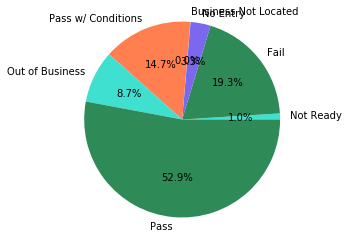

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = countResultsdf['results']
sizes = countResultsdf['cnt']
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')

In [156]:
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData = df.select(label(df.results).alias('label'), df.violations).where('label >= 0').fillna("null")

In [158]:
labeledDataSplits = labeledData.randomSplit([0.8, 0.2])
trainData = labeledDataSplits[0]
testData = labeledDataSplits[1]

In [159]:
trainData.take(1)

[Row(label=0.0, violations='1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLEDGE, AND PERFORMS DUTIES - Comments:  2-101.11 PERSON IN CHARGE DOES NOT POSSESS A CITY OF CHICAGO SANITATION CERTIFICATE. INSTRUCTED ALL PERSONS IN CHARGE MUST HAVE A CITY SANITATION CERTIFICATE. PRIORITY FOUNDATION VIOLATION. NO CITATION ISSUED. | 25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCOOKED FOOD - Comments:  3-603.11 MENU DOES NOT DISCLOSE AND INFORM CONSUMERS THE SPECIFIC MENU ITEMS THAT ARE RAW OR UNDER COOKED AND A POTENTIAL HAZARD OF CONSUMING SUCH FOOD. MUST PROVIDE A CONSUMER ADVISORY AND DISCLOSE SUCH ITEMS. PRIORITY FOUNDATION VIOLATION. NO CITATION ISSUED. | 37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER - Comments:  3-602.11(A; B:1-4,6,7; C; D) ALL PREPACKAGED PREPARED FOODS IN THE FRONT DISPLAY COOLER SUCH AS: PASTA SALAD, SANDWICHES, GREEN SALADS MUST BE PROPERLY LABELED WITH BUSINESS NAME, ADDRESS AND LIST OF INGREDIENTS. | 37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER - Comments:  3-602.11

In [160]:
tokenizer = Tokenizer(inputCol="violations", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

model = pipeline.fit(labeledData)

In [161]:
predictionsDf = model.transform(testData)
predictionsDf.registerTempTable('Predictions')
predictionsDf.columns

['label',
 'violations',
 'words',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [162]:
predictionsDf.take(1)

[Row(label=0.0, violations="1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLEDGE, AND PERFORMS DUTIES - Comments:  PERSON IN CHARGE AT THE TIME OF INSPECTION DOES NOT HAVE A CITY OF CHICAGO SANITATION CERTIFICATE. PRIORITY FOUNDATION VIOLATION. NO CITATION ISSUED - | 3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: FOUND NO EMPLOYEE HEALTH POLICY/TRAINING ON SITE. INSTRUCTED FACILITY TO ESTABLISH AN APPROPRIATE EMPLOYEE HEALTH POLICY/TRAINING SYSTEM AND MAINTAIN WITH VERIFIABLE DOCUMENTS ON SITE. PRIORITY FOUNDATION VIOLATION 7-38-010. NO CITATION ISSUED | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: FOUND NO PROCEDURE/PLAN AND KIT FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS. INSTRUCTED FACILITY TO DEVELOP AND MAINTAIN A PROCEDURE/PLAN AND KIT TO MAINTAIN ANY APPROPRIATE SUPPLIES ON SITE. PRIORITY FOUNDATION VIOLATION 7-38-005.NO CITATION ISSUED   | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI

In [163]:
numSuccesses = predictionsDf.where("""(prediction = 0 AND results = 'Fail') OR
                                        (prediction = 1 AND (results = 'Pass' OR
                                                            results = 'Pass w/ Conditions'))""").count()
numInspections = predictionsDf.count()

print("There were", numInspections, "inspections and there were", numSuccesses, "successful predictions")
print("This is a", str((float(numSuccesses) / float(numInspections)) * 100) + "%", "success rate")

There were 35742 inspections and there were 34643 successful predictions
This is a 96.92518605562084% success rate


In [164]:
true_positive = predictionsDf.where("prediction = 0 AND results = 'Fail'").count()

In [165]:
false_positive = predictionsDf.where("prediction = 0 AND (results = 'Pass' OR results = 'Pass w/ Conditions')").count()

In [166]:
true_negative = predictionsDf.where("prediction = 1 AND results = 'Fail'").count()

In [167]:
false_negative = predictionsDf.where("prediction = 1 AND (results = 'Pass' OR results = 'Pass w/ Conditions')").count()

(-1.1047212236212636,
 1.1002248201724412,
 -1.1053092053565108,
 1.101589266482251)

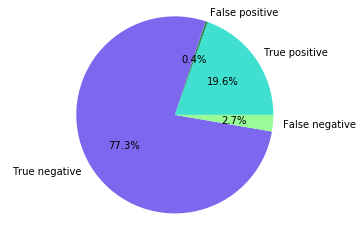

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = ['True positive', 'False positive', 'True negative', 'False negative']
sizes = [true_positive, false_positive, false_negative, true_negative]
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')